In [56]:
import os 
import scipy
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tqdm import tqdm
import tensorflow_addons as tfa
import datetime
mpl.rcParams['figure.figsize'] = [18.0, 6.0]

## 함수 정의 하는 부분

In [92]:
# 시계열 크기 나누는 부분
def my_split_window(series, window):
    X = []
    y = []
    n_steps = len(series) - window

    for step in range(n_steps):
        X.append(series[step:window+step])
        y.append(series[step + window])
    X = np.array(X)
    y = np.array(y)
    
    return X, y

# train , valid , test size 나누는 function
def split(df , window , size = 0.3):
    df = df['t'].values
    X ,y = my_split_window(df , window)
    x_train, x_valid_p, y_train, y_valid_p = train_test_split(X, y, test_size= size, shuffle = False)
    x_valid , x_test , y_valid , y_test = train_test_split(x_valid_p, y_valid_p, test_size=0.8 , shuffle = False)
    print(x_train.shape , y_train.shape , x_valid.shape , x_test.shape , y_valid.shape ,x_test.shape ,  y_test.shape)

    return x_train , y_train , x_valid , y_valid , x_test, y_test

#그래프 그리는 함수
def split_plot(df , y_train , y_valid , y_test , window):

    plt.plot(df)
    plt.axvspan(len(df) - len(y_test) - len(y_valid) , len(df) - len(y_test) , facecolor = 'green' , alpha = 0.15)
    plt.axvspan( len(df)- len(y_test) , len(df) , facecolor = 'red' , alpha = 0.15)
    plt.axvspan(len(df) - len(y_test) - len(y_valid) - len(y_train), len(df) - len(y_test) - len(y_valid), facecolor = 'blue' , alpha = 0.15)
    plt.axvline(x =len(df) - len(y_valid) - len(y_test) -window, ymin=0, ymax=1 ,color = 'green' , alpha = 0.7) 
    plt.axvline(x =len(df) - len(y_test) -window, ymin=0, ymax=1 ,color = 'red' , alpha = 0.7) 
    plt.show()
    
# model fit하는 function
def model_fit(x_train , y_train , x_valid , y_valid ,  model_name):
    start = datetime.datetime.now()
    model.compile(optimizer = 'adam'  , loss = 'mae')
    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    filename = os.path.join(model_path, f'{model_name}.h5')
    tqdm_callback = tfa.callbacks.TQDMProgressBar( leave_epoch_progress=False )
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
    x_valid = x_valid.reshape((x_valid.shape[0], x_valid.shape[1], 1))
    checkpoint = ModelCheckpoint(filename, monitor='val_loss', save_best_only=True)
    history = model.fit(x_train , y_train , epochs = 500 , verbose = 0 , 
                        callbacks=[early_stop, checkpoint , tqdm_callback] ,
                         validation_data = (x_valid  , y_valid))
    end = datetime.datetime.now()
    print(model.summary())
    time = (end - start)
    print('처리시간:' , time)
    return history 

#손실값 그래프
def loss_fn(history):
    plt.plot(history.history['loss']  , label  = 'loss')
    plt.plot(history.history['val_loss']  , label = 'val_loss' )
    plt.title('Loss' , fontsize = 20)
    plt.legend(fontsize = 20)
    plt.show()

#구조에 맞게 reshape
def reshape(x):
    return x.reshape(x.shape[0], x.shape[1]  , 1)

#예측값 시각화
def predict_plot(y_valid , y_valid_pred , y_test , y_test_pred , window):    
    plt.figure(figsize = (14 , 10))
    plt.subplot(2, 1,1)
    plt.plot(y_valid ) 
    plt.plot(y_valid_pred)
    plt.title('Time Sequence {} , validation data'.format(window))
    plt.subplot(2 ,1,2)
    plt.plot(y_test)
    plt.plot(y_test_pred)
    plt.title('Time Sequence {} , Test Data'.format(window))
    plt.show()

In [34]:
df  = pd.read_csv('dataset/prepro.csv' , index_col = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22608 entries, 0 to 22607
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       22608 non-null  float64
dtypes: float64(1)
memory usage: 353.2 KB


In [35]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['t']
df = scaler.fit_transform(df[scale_cols])
df = pd.DataFrame(df)
df.columns = scale_cols
df.tail()

,t
22603,0.756198
22604,0.756409
22605,0.756618
22606,0.756824
22607,0.757029


In [36]:
#데이터 22000 -> 15000
df_l = df[:15000]
df_l.tail()

,t
14995,0.999836
14996,0.999857
14997,0.999877
14998,0.999896
14999,0.999913


In [37]:
x_train365 , y_train365 , x_valid365 , y_valid365 , x_test365, y_test365 = split(df_l , 365)

(10244, 365) (10244,) (878, 365) (3513, 365) (878,) (3513, 365) (3513,)


### 데이터를 예측하기 이전에 설정한 window 사이즈 만큼 넣어줘야 하기 때문에 
1. 초록색 수직선 부터 초록색 구간 이전까지 365개의 데이터를 삽입
2. 초록색 구간 처음부터 끝까지를 예측

## test 데이터
1. 빨간색 수직선 부터 빨간색 구간 이전까지 365개 데이터를 삽입
2. 빨간색 구간 처음부터 끝까지를 예측

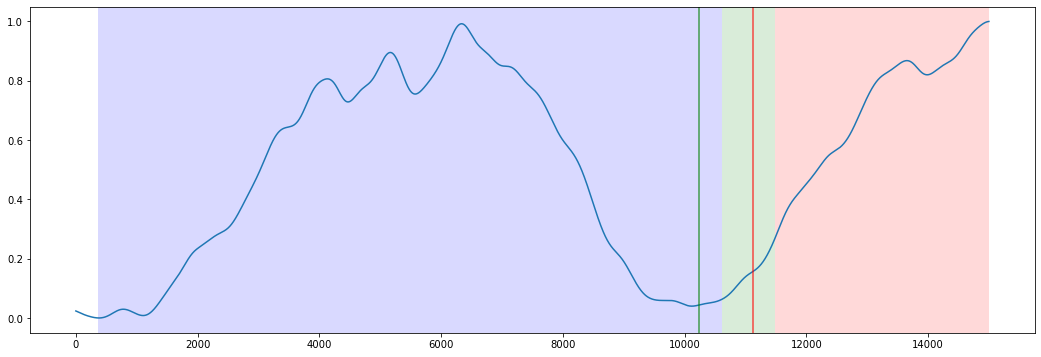

In [93]:
split_plot(df_l , y_train365 , y_valid365 , y_test365 , 365)

### 1차적으로 모델 정의 하는 부분

In [66]:
model = tf.keras.Sequential()                        
model.add(tf.keras.layers.LSTM(10 , return_sequences = False ))
model.add(tf.keras.layers.Dense(1))

In [67]:
model_path = 'model/'

In [68]:
history_365_c10 =  model_fit(x_train365 , y_train365 , x_valid365 , y_valid365 , 365)

Training:   0%|                                                                               0/500 ETA: ?s,  …

Epoch 1/500


0/321                                                                                                        E…

Epoch 2/500


0/321                                                                                                        E…

Epoch 3/500


0/321                                                                                                        E…

Epoch 4/500


0/321                                                                                                        E…

Epoch 5/500


0/321                                                                                                        E…

Epoch 6/500


0/321                                                                                                        E…

Epoch 7/500


0/321                                                                                                        E…

Epoch 8/500


0/321                                                                                                        E…

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
None
처리시간: 0:00:35.585871


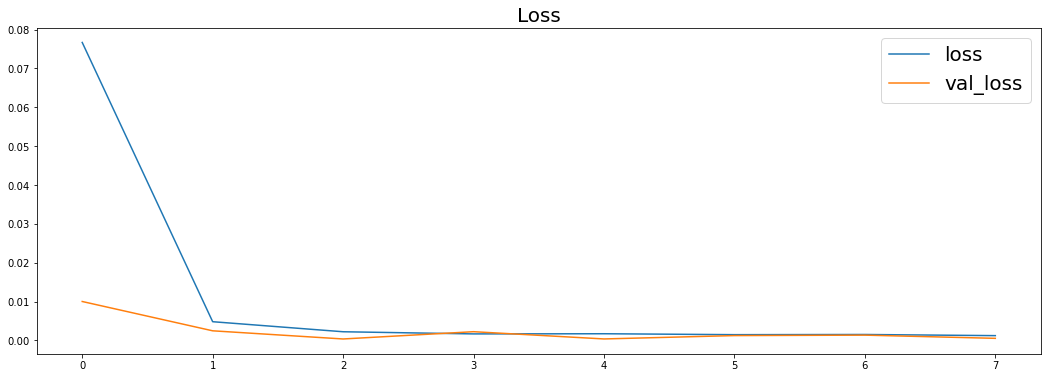

In [69]:
loss_fn(history_365_c10 )

lstm 모델은 2차원이 아닌 3차원으로 들어가기 때문에 reshape function을 통한 틀 바꾸기

In [70]:
x_test365 = reshape(x_test365)
x_valid365 = reshape(x_valid365)
y_test_pred365 = model.predict(x_test365)
y_valid_pred365 = model.predict(x_valid365)

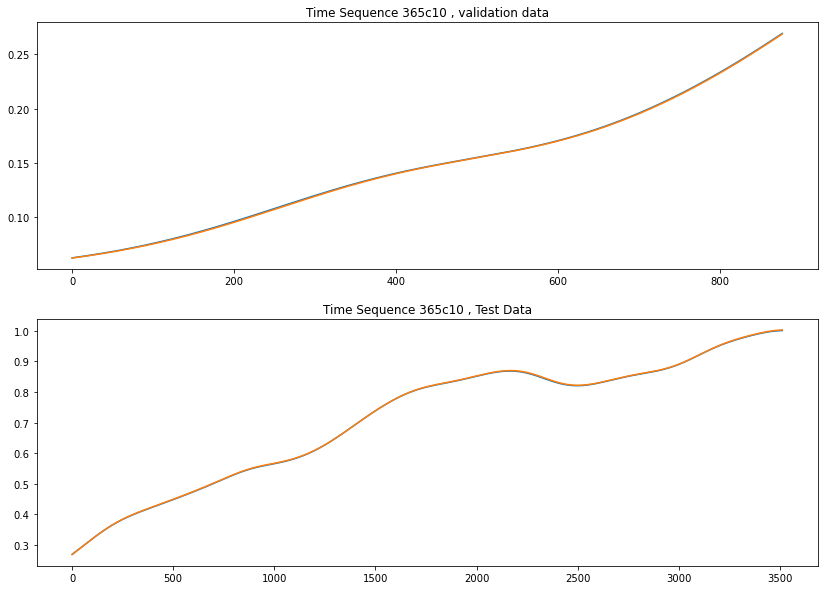

In [71]:
predict_plot(y_valid365 , y_valid_pred365 , y_test365 , y_test_pred365 , '365c10')

In [72]:
x_train8000 , y_train8000 , x_valid8000 , y_valid8000 , x_test8000, y_test8000 = split(df , 8000 , size = 0.5)

(7304, 8000) (7304,) (1460, 8000) (5844, 8000) (1460,) (5844, 8000) (5844,)


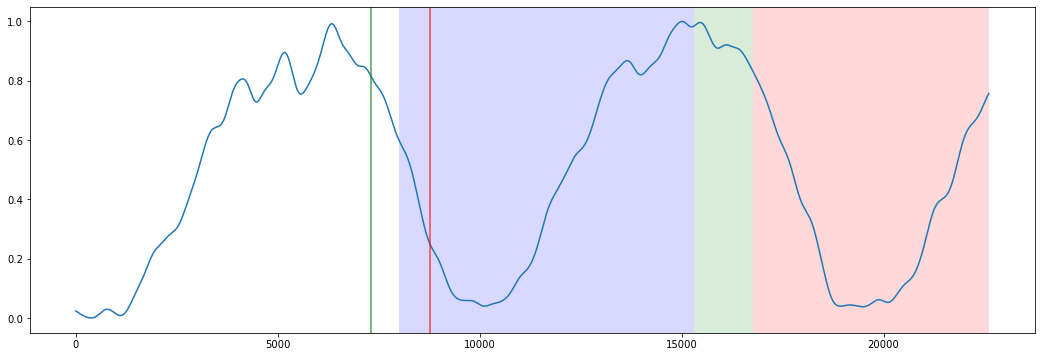

In [94]:
split_plot(df , y_train8000 , y_valid8000 , y_test8000 , 8000)

In [76]:
model = tf.keras.Sequential()                        
model.add(tf.keras.layers.LSTM(32 , return_sequences = False ))
model.add(tf.keras.layers.Dense(1))

In [77]:
history_8000c32 =  model_fit(x_train8000 , y_train8000 , x_valid8000 , y_valid8000, '8000c32'  )

Training:   0%|                                                                               0/500 ETA: ?s,  …

Epoch 1/500


0/229                                                                                                        E…

Epoch 2/500


0/229                                                                                                        E…

Epoch 3/500


0/229                                                                                                        E…

Epoch 4/500


0/229                                                                                                        E…

Epoch 5/500


0/229                                                                                                        E…

Epoch 6/500


0/229                                                                                                        E…

Epoch 7/500


0/229                                                                                                        E…

Epoch 8/500


0/229                                                                                                        E…

Epoch 9/500


0/229                                                                                                        E…

Epoch 10/500


0/229                                                                                                        E…

Epoch 11/500


0/229                                                                                                        E…

Epoch 12/500


0/229                                                                                                        E…

Epoch 13/500


0/229                                                                                                        E…

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
None
처리시간: 0:12:29.557044


In [78]:
x_test8000 = reshape(x_test8000)
x_valid8000 = reshape(x_valid8000)
y_test_pred8000 = model.predict(x_test8000)
y_valid_pred8000 = model.predict(x_valid8000)

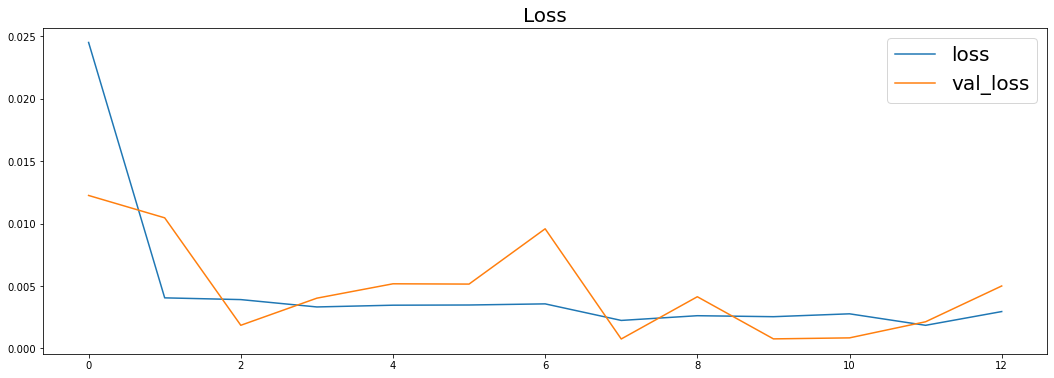

In [80]:
loss_fn(history_8000c32 )

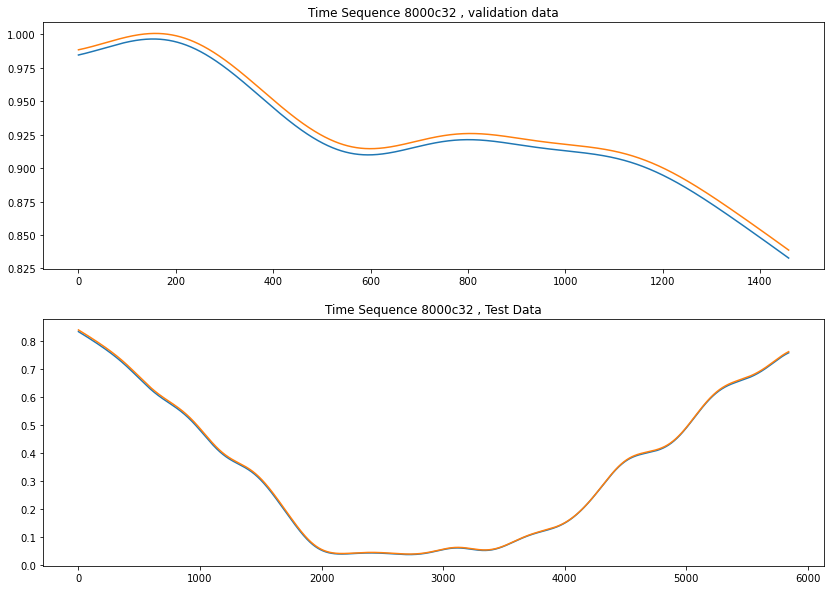

In [81]:
predict_plot(y_valid8000 , y_valid_pred8000 , y_test8000 , y_test_pred8000 , '8000c32')

##  전처리 거친 데이터를 학습시키고 예측할 때는 original data로 예측하기 

In [82]:
df_O  = pd.read_csv('dataset/original.csv' , index_col = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22608 entries, 0 to 22607
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       22608 non-null  float64
dtypes: float64(1)
memory usage: 176.8 KB


In [83]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['t']
df_O = scaler.fit_transform(df_O[scale_cols])
df_O = pd.DataFrame(df_O)
df_O.columns = scale_cols
df_O.tail()

,t
22603,0.768846
22604,0.767692
22605,0.766538
22606,0.765769
22607,0.764615


In [84]:
x_train8000 , y_train8000 , x_valid8000 , y_valid8000 , x_test8000, y_test8000 = split(df_O , 8000 , size = 0.5)

(7304, 8000) (7304,) (1460, 8000) (5844, 8000) (1460,) (5844, 8000) (5844,)


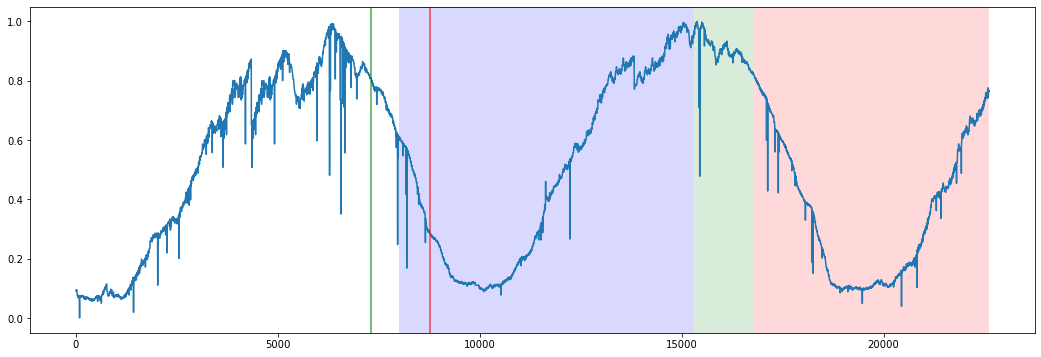

In [95]:
split_plot(df_O , y_train8000 , y_valid8000 , y_test8000 , 8000)

In [86]:
x_test8000 = reshape(x_test8000)
x_valid8000 = reshape(x_valid8000)
y_test_pred8000 = model.predict(x_test8000)
y_valid_pred8000 = model.predict(x_valid8000)

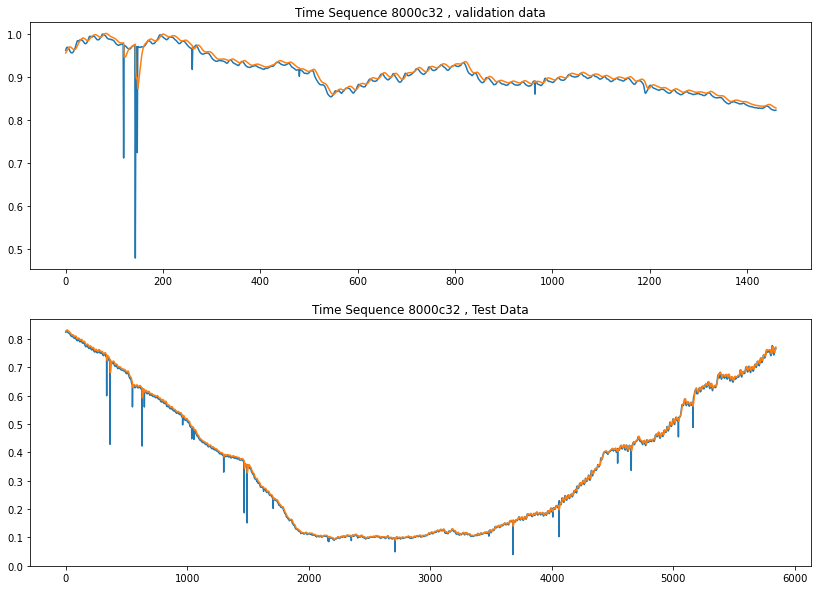

In [87]:
predict_plot(y_valid8000 , y_valid_pred8000 , y_test8000 , y_test_pred8000 , '8000c32')